### <b>Dataset Download</b>

* This gender classification dataset has total <b>58,658 images</b>. (train: 47,009 / val: 11,649)
* <b>Dataset</b>: [Kaggle Gender Classification Dataset](https://www.kaggle.com/cashutosh/gender-classification-dataset)

<pre>
<b>Dataset</b>/
    <b>Training</b>/
        <b>female</b>/
          23,243 images
        <b>male</b>/
          23,766 images
    <b>Validation</b>/
        <b>female</b>/
          5,841 images
        <b>male</b>/
          5,808 images
</pre>

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdWfjq2Cu49Bv6xnZ4FHeswBZSrbikXZqPdLrP8pFhwfQQ?download=1 -O gender_classification_dataset.zip
!unzip gender_classification_dataset.zip -d ./gender_classification_dataset

In [6]:
#%%capture
#!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdWfjq2Cu49Bv6xnZ4FHeswBZSrbikXZqPdLrP8pFhwfQQ?download=1 -O gender_classification_dataset.zip
!unzip gender_classification_dataset.zip -d ./gender_classification_dataset

Archive:  gender_classification_dataset.zip
  inflating: ./gender_classification_dataset/Training/female/131422.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131423.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131425.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131427.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131428.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131429.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131432.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131433.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131435.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131437.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131440.jpg.jpg  
  inflating: ./gender_classification_dataset/Training/female/131449.jpg.jpg  
  inflating: ./gende

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './gender_classification_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms_train)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transforms_val)
val_datasets, test_datasets = torch.utils.data.random_split(val_data, [5000, 6649])

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_datasets))
print('Validation dataset size:', len(val_datasets))
print('Test dataset size:', len(test_datasets))

class_names = train_datasets.classes
print('Class names:', class_names)

FileNotFoundError: [Errno 2] No such file or directory: './gender_classification_dataset/Training'

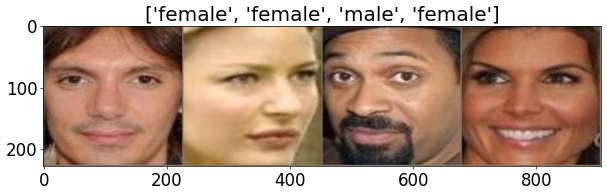

In [45]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [4]:
import copy
#model = models.resnet18(pretrained=True)
#num_features = model.fc.in_features
#model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
#model = model.to(device)
#best_model_wts = copy.deepcopy(model.state_dict())
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [46]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the last classification layer for multiclass classification
num_ftrs = resnet.fc.in_features
num_classes = 2  # Replace with the number of classes in your dataset
resnet.fc = nn.Linear(num_ftrs, num_classes)

# Create a custom model that returns both the output and intermediate features
class ResNetMulticlassWithFeatures(nn.Module):
    def __init__(self, resnet):
        super(ResNetMulticlassWithFeatures, self).__init__()
        num_ftrs = resnet.fc.in_features
        num_classes = 2
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        features = self.features(x)
        output = self.classifier(features)
        return output, features

# Create an instance of the custom model
model = ResNetMulticlassWithFeatures(resnet).to(device)
best_model_wts = copy.deepcopy(model.state_dict())
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1.0e-4)

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(model)

ResNetMulticlassWithFeatures(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [47]:
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path,history):
    f_path = checkpoint_path
    torch.save(state, f_path)
    torch.save(history, '/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/history.pt')
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [48]:
try:
  os.mkdir(f'/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models')
except:
  print('already exists')
checkpoint_path = "/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/current_checkpoint.pt"
best_model_path = "/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/best_model.pt"


already exists


### <b>Training Phase</b>


In [49]:
num_epochs = 30
start_time = time.time()
history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}
valid_loss_min = np.inf
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, epochs=num_epochs, steps_per_epoch=len(train_dataloader))
for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    train_loss = 0.
    train_acc = 0.
    t_conf=[]
    t_f=[]
    t_l=[]
    t_o=[]
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print(labels.shape)
        # forward inputs and get output
        optimizer.zero_grad()
        
        outputs,features = model(inputs)
        #print(outputs.shape)
        t_f.append(features.cpu())
        t_l.append(labels.cpu())
        t_o.append(outputs.cpu())
        
        probs = torch.nn.functional.softmax(outputs, dim=1)
        t_conf.append(probs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(preds == labels.data).cpu().numpy()

    train_loss = train_loss / len(train_datasets)
    train_acc = train_acc / len(train_datasets) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, train_loss, train_acc, time.time() - start_time))
    
    """ Validation Phase """
    model.eval()

    with torch.no_grad():
        val_loss = 0.
        val_acc = 0.
        v_conf=[]
        v_f,v_l,v_o=[],[],[]

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs,features = model(inputs)
            v_f.append(features.cpu())
            v_l.append(labels.cpu())
            v_o.append(outputs.cpu())
            probs = torch.nn.functional.softmax(outputs, dim=1)
            v_conf.append(probs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(preds == labels.data).cpu().numpy()

        val_loss = val_loss / len(val_datasets)
        val_acc = val_acc / len(val_datasets) * 100.
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, val_loss, val_acc, time.time() - start_time))
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

best_model_wts = copy.deepcopy(model.state_dict())
#torch.save(model.state_dict(), '/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/model_{:.2f}%acc.h5'.format(val_acc))
checkpoint = {
            'valid_loss_min': val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }

        # save checkpoint
save_ckp(checkpoint, False, checkpoint_path, best_model_path,history)

        ## TODO: save the model if validation loss has decreased
if val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,val_loss))
            # save checkpoint as best model
    save_ckp(checkpoint, True, checkpoint_path, best_model_path,history)
    valid_loss_min = val_loss


[Train #0] Loss: 0.1465 Acc: 94.7712% Time: 83.6780s
[Validation #0] Loss: 0.1097 Acc: 95.9800% Time: 86.9826s
[Train #1] Loss: 0.1222 Acc: 95.6710% Time: 171.6149s
[Validation #1] Loss: 0.0951 Acc: 96.8400% Time: 174.9214s
[Train #2] Loss: 0.1171 Acc: 95.9476% Time: 259.9866s
[Validation #2] Loss: 0.1011 Acc: 96.2400% Time: 263.3424s
[Train #3] Loss: 0.1112 Acc: 96.1050% Time: 347.9466s
[Validation #3] Loss: 0.0914 Acc: 96.6000% Time: 351.2271s
[Train #4] Loss: 0.1044 Acc: 96.2645% Time: 436.1999s
[Validation #4] Loss: 0.0975 Acc: 96.5800% Time: 439.4524s
[Train #5] Loss: 0.0987 Acc: 96.5879% Time: 523.1178s
[Validation #5] Loss: 0.0846 Acc: 97.1200% Time: 526.4781s
[Train #6] Loss: 0.0952 Acc: 96.7070% Time: 610.1758s
[Validation #6] Loss: 0.0819 Acc: 97.2000% Time: 613.6213s
[Train #7] Loss: 0.0908 Acc: 96.8474% Time: 696.8959s
[Validation #7] Loss: 0.1047 Acc: 96.0200% Time: 700.1908s
[Train #8] Loss: 0.0865 Acc: 96.9878% Time: 783.5360s
[Validation #8] Loss: 0.0987 Acc: 96.5000% T

In [57]:
save_path = 'face_gender_classification_transfer_learning_with_ResNet18.pth'
torch.save(model.state_dict(), save_path)

In [58]:

params = []
for param in model.parameters():
    params.append(param.view(-1))
params = torch.cat(params)
print(params.shape)
print(params)

torch.Size([11177538])
tensor([2.9862e-40, 2.9834e-40, 1.7302e-40,  ..., 8.0134e-04, 2.8572e-02,
        1.1482e-02], device='cuda:0', grad_fn=<CatBackward>)


In [59]:
torch.save(t_f, '/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/t_f.pt')
torch.save(t_l, '/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/t_l.pt')
torch.save(t_o, '/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/t_o.pt')

* Evaluate the trained model.

[Prediction Result Examples]


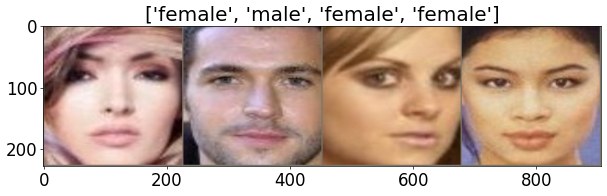

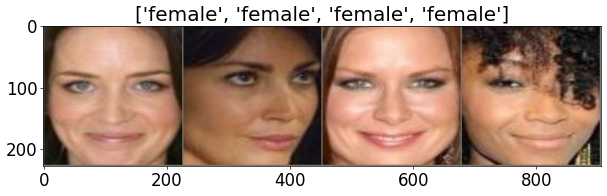

[Test #29] Loss: 0.0887 Acc: 96.7664% Time: 4.7345s


In [60]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    feat=[]
    la=[]
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print(inputs.shape)
        outputs,features = model(inputs)
        feat.append(features.cpu())
        la.append(labels.cpu())
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

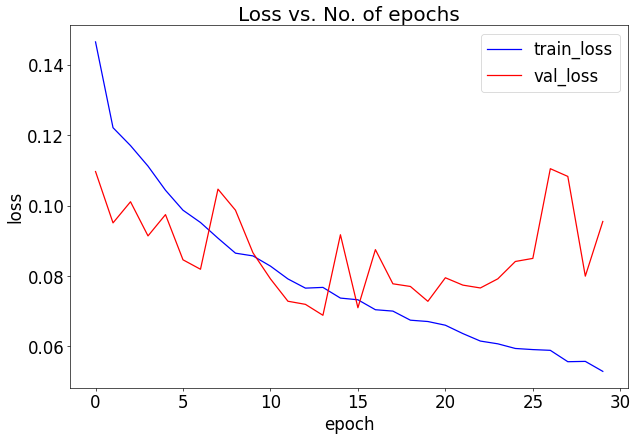

In [61]:
history=torch.load('/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/history.pt')
plt.plot(history['train_loss'], '-b',label ='train_loss')
plt.plot(history['val_loss'], '-r',label ='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs')
plt.savefig("loss_curve.png")

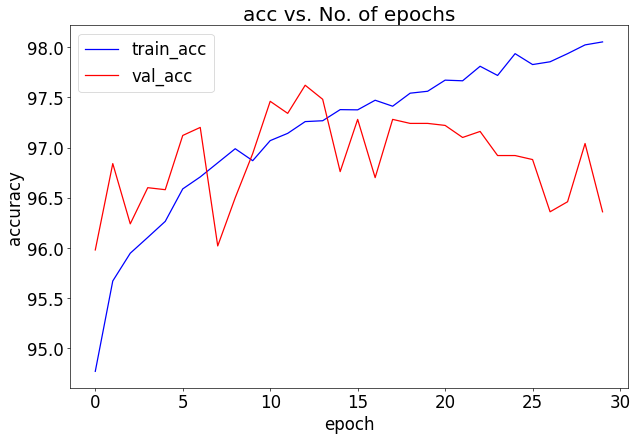

In [62]:
history=torch.load('/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/history.pt')
plt.plot(history['train_acc'], '-b',label ='train_acc')
plt.plot(history['val_acc'], '-r',label ='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('acc vs. No. of epochs')
plt.savefig("acc_curve.png")

In [63]:
f=torch.load('/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/t_f.pt')
l=torch.load('/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/t_l.pt')
o=torch.load('/home/tasnim123109/FaceRace/stylegan-pretrained/cl_models/t_o.pt')
f1=torch.cat(f,dim=0)
print(f1.shape)
l1=torch.cat(l,dim=0)
o1=torch.cat(o,dim=0)
print(l1.shape)
print(o1.shape)
print(params.shape)

torch.Size([47009, 512, 1, 1])
torch.Size([47009])
torch.Size([47009, 2])
torch.Size([11177538])


In [64]:
def plot_data(inputs,targets,weights):
    # fig config
    inputs=inputs.detach().numpy()
    targets=targets.detach().numpy()
    weights=weights.cpu().detach().numpy()
    plt.figure(figsize=(10,6))
    plt.grid(True)

    for input,target in zip(inputs,targets):
        plt.plot(input[0],input[1],'ro' if (target == 0) else 'bo')

    # Here i am calculating slope and intercept with given three weights
    for i in np.linspace(np.amin(inputs[:,:1]),np.amax(inputs[:,:1])):
        slope = -(weights[0]/weights[2])/(weights[0]/weights[1])  
        intercept = -weights[0]/weights[2]

        #y =mx+c, m is slope and c is intercept
        y = (slope*i) + intercept
        #print(y)
        plt.plot(i, y,'ko')

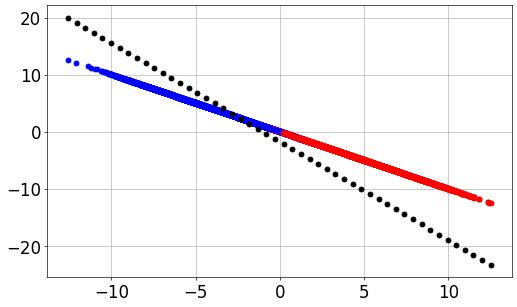

In [65]:
plot_data(o1,l1,params)

In [54]:
a=features
print(a.shape)
b=a.squeeze().cpu().numpy()
print(b.shape)
c=b.reshape(-1, 1)
print(c.shape)
print(labels)

torch.Size([1, 2048, 1, 1])
(2048,)
(2048, 1)
tensor([1], device='cuda:0')


Files already downloaded and verified


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ 1.5449278 -1.5160927]
 [-5.3710804  5.405925 ]
 [ 4.9693694 -4.940558 ]
 ...
 [ 6.478987  -6.4535418]
 [-0.6102502  0.6431885]
 [ 8.878308  -8.85781  ]]


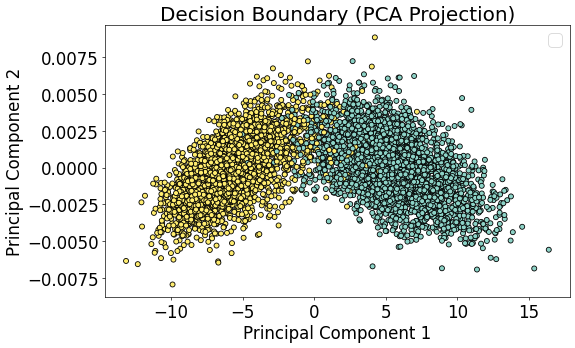

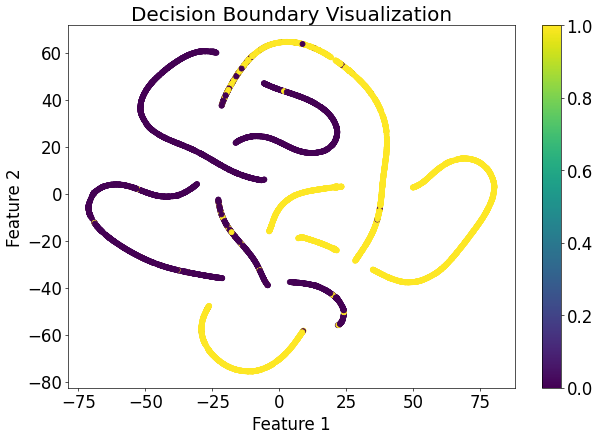

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(cifar_dataset, batch_size=100, shuffle=True)

# Load a pre-trained ResNet-18 model
#model = torchvision.models.resnet18(pretrained=True)
#model = model.eval()
model.eval()
# Extract features using the pre-trained model
features = []
labels = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images=images.to(device)
        targets=targets.to(device)
        outputs,in_fe = model(images)
        features.append(outputs.cpu())
        labels.append(targets.cpu())

features = torch.cat(features).numpy()
print(features)
labels = torch.cat(labels).numpy()

# Apply PCA for dimensionality reduction (you may adjust the number of components)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Visualize the reduced data points and decision boundary
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap=plt.cm.Set3, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Legend
#legend1 = plt.Line2D([0], [0], marker='o', color='w', label='female', markerfacecolor='r', markersize=10)
#legend2 = plt.Line2D([0], [0], marker='o', color='w', label='male', markerfacecolor='g', markersize=10)
#legend3 = plt.Line2D([0], [0], marker='o', color='w', label='Class 2', markerfacecolor='b', markersize=10)
plt.legend()

plt.title('Decision Boundary (PCA Projection)')
plt.show()

tsne = TSNE(n_components=2, perplexity=50)  # You can adjust perplexity
reduced_features = tsne.fit_transform(features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1],c=labels, cmap='viridis')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary Visualization')
plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

In [15]:
test = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=True)
X = []
Y = []
for inputs,labels in test:
    X.append(inputs.squeeze().numpy())
    Y.append(labels.squeeze().numpy())
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)
len(x_train), len(x_test)


NameError: name 'train_test_split' is not defined

In [11]:
test = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=True)
for inputs,labels in test:
    i=inputs.squeeze().reshape([512,294])
    print(i.shape)

torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size([512, 294])
torch.Size(

In [6]:
classifier = MLPClassifier(hidden_layer_sizes=(10,40,40,40), max_iter=200,activation = 'relu',solver='adam',random_state=1)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_pred, y_test)
cm

ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
x_min = X[0][0]
x_max = X[0][0]
y_min = X[1][1]
y_max = X[1][1]
for i in range(len(X)):
    x_min = min(x_min, X[i][0])
    x_max = max(x_max, X[i][0])
    y_min = min(y_min, X[i][1])
    y_max = max(y_max, X[i][1])
x_min, x_max, y_min, y_max

In [ ]:
xx, yy = np.meshgrid(np.arange(x_min-1, x_max+1, 0.2), np.arange(y_min-1, y_max+1, 0.2))

In [ ]:
xx.shape, yy.shape

In [ ]:
z = np.array([xx.ravel(), yy.ravel()]).T
z.shape

In [ ]:
labels = classifier.predict(z)
labels.shape

In [ ]:
colors = {0.0:"purple", 1.0:"goldenrod"}

In [ ]:
plt.contourf(xx, yy, labels.reshape(xx.shape), alpha = 0.3)
plt.scatter(data['age'], data['interest'], c = data['success'].map(colors))